# 1. Identitas

* Nama : Muhammad Itsar Rabbani
* Batch : 006
* Milestone 02 Phase 02
* Notebook Objective :
  * Create some analysis about customers from Amazon Kindle Book review data
  * Create a Deep Learning Natural Language Processing (NLP) model to predict rating value based on the review text provided by the customer

* Dataset from : https://www.kaggle.com/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis

# 2. Import Pustaka

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#preprocess
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Embedding, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'nltk'

# 3. Data Load

### Import with Kaggle

In [81]:
#permission access kaggle to root
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [82]:
#kaggle on default folder
!mkdir ./kaggle
!mv ./kaggle.json /kaggle

mkdir: cannot create directory ‘./kaggle’: File exists


In [83]:
#granting access permission
!chmod 600 ~/.kaggle/kaggle.json

In [84]:
#download dataset
!kaggle datasets download -d meetnagadia/amazon-kindle-book-review-for-sentiment-analysis
!mkdir amazon_review
!unzip amazon-kindle-book-review-for-sentiment-analysis -d amazon_review

amazon-kindle-book-review-for-sentiment-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘amazon_review’: File exists
Archive:  amazon-kindle-book-review-for-sentiment-analysis.zip
replace amazon_review/all_kindle_review .csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace amazon_review/preprocessed_kindle_review .csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


### The Dataset

In [85]:
df = pd.read_csv('/content/amazon_review/all_kindle_review .csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


In [86]:
#dataset dimension
df.shape

(12000, 11)

In [87]:
#dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      12000 non-null  int64 
 1   Unnamed: 0.1    12000 non-null  int64 
 2   asin            12000 non-null  object
 3   helpful         12000 non-null  object
 4   rating          12000 non-null  int64 
 5   reviewText      12000 non-null  object
 6   reviewTime      12000 non-null  object
 7   reviewerID      12000 non-null  object
 8   reviewerName    11962 non-null  object
 9   summary         12000 non-null  object
 10  unixReviewTime  12000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 1.0+ MB


In [88]:
#looking for missing value
df.isnull().sum()

Unnamed: 0         0
Unnamed: 0.1       0
asin               0
helpful            0
rating             0
reviewText         0
reviewTime         0
reviewerID         0
reviewerName      38
summary            0
unixReviewTime     0
dtype: int64

In [89]:
#looking for duplicated data
df.duplicated().value_counts()

False    12000
dtype: int64

# 4. Data Cleaning

In general, data cleaning on this notebook will handle missing values and also adjust some column features because in our opinion there are some columns that tend to be unused in making NLP Deep Learning models.

Fortunately, the column that contains missing values is included in the unused column so that we can directly drop the column to that column without having to remove some of the data

In [90]:
#new dataset
new = df.copy()
new = df[['reviewText', 'rating']]
new

,reviewText,rating
0,"Jace Rankin may be short, but he's nothing to ...",3
1,Great short read. I didn't want to put it dow...,5
2,I'll start by saying this is the first of four...,3
3,Aggie is Angela Lansbury who carries pocketboo...,3
4,I did not expect this type of book to be in li...,4
...,...,...
11995,Valentine cupid is a vampire- Jena and Ian ano...,4
11996,I have read all seven books in this series. Ap...,5
11997,This book really just wasn't my cuppa. The si...,3
11998,"tried to use it to charge my kindle, it didn't...",1


In [91]:
#dimensionality of new dataset
new.shape

(12000, 2)

In [92]:
#re-check the missing values
new.isnull().sum()

reviewText    0
rating        0
dtype: int64

# 5. Exploratory Data Analysis

In [93]:
#create new dataframe
another = new.copy()

### Extra Features

Create Sentiment Features

In [94]:
another.loc[another['rating'] == 3,'sentiment'] = 'Neutral'
another.loc[another['rating'] < 3,'sentiment'] = 'Negative'
another.loc[another['rating'] > 3,'sentiment'] = 'Positive'

Create Stop Words Features

In [95]:
#set the stopwords filter
filter_stopwords = set(stopwords.words('english'))

#create
another['stopwords'] = another['reviewText'].apply(lambda x: len([x for x in x.split() if x in filter_stopwords]))

Create Punctuation Features

In [96]:
#set the function
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

#apply
another['punctuation'] = another['reviewText'].apply(lambda x: count_punct(x))

Create Hashtag Features

In [97]:
another['hastags'] = another['reviewText'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

Create Numbers Features

In [98]:
another['numerics'] = another['reviewText'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

Create Number + Average Words

In [99]:
#Average Words
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/(len(words)+0.000001))

In [100]:
#Number of Character
another['char_count'] = another['reviewText'].str.len()
#Apply Average Words
another['avg_word'] = another['reviewText'].apply(lambda x: avg_word(x)).round(1)

Dataset with Extra Features

In [101]:
another.head()

,reviewText,rating,sentiment,stopwords,punctuation,hastags,numerics,char_count,avg_word
0,"Jace Rankin may be short, but he's nothing to ...",3,Neutral,238,87,0,0,2921,4.4
1,Great short read. I didn't want to put it dow...,5,Positive,24,12,0,0,371,4.3
2,I'll start by saying this is the first of four...,3,Neutral,28,19,0,2,416,4.5
3,Aggie is Angela Lansbury who carries pocketboo...,3,Neutral,20,8,0,0,336,5.2
4,I did not expect this type of book to be in li...,4,Positive,11,0,0,0,90,3.5


### Visualization

The Data below is some random samples from our dataset after added some features at previous section.

In [102]:
another.sample(5)

,reviewText,rating,sentiment,stopwords,punctuation,hastags,numerics,char_count,avg_word
1935,Was a really great read just wish there would ...,3,Neutral,11,2,0,0,101,3.9
6494,Nope. I tried. Can't read it. I will take the ...,1,Negative,7,6,0,0,118,4.2
1720,The story line just drug on and on. I did not ...,2,Negative,16,2,0,0,141,3.4
9120,I have read several angel books but this one d...,1,Negative,45,11,0,0,485,3.9
360,Possibly the worst book I have ever read. The...,1,Negative,40,16,0,0,497,4.5


**View The Dataset in Statistics**

In [103]:
another.describe().T.round(0)

,count,mean,std,min,25%,50%,75%,max
rating,12000.0,3.0,1.0,1.0,2.0,4.0,4.0,5.0
stopwords,12000.0,47.0,56.0,0.0,13.0,26.0,59.0,956.0
punctuation,12000.0,18.0,23.0,0.0,5.0,10.0,22.0,370.0
hastags,12000.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
numerics,12000.0,0.0,1.0,0.0,0.0,0.0,0.0,16.0
char_count,12000.0,602.0,710.0,7.0,171.0,332.0,737.0,12246.0
avg_word,12000.0,4.0,0.0,3.0,4.0,4.0,5.0,9.0


From our table above we can see that the maximum character value can reach 12,246 characters with an average value of 602 characters. Even in the stopwords and punctuation columns, the values are 956 and 370, respectively, with an average value of 47 stopwords and 18 punctuation.

Now let's see the outliers and its distribution through Seaborn

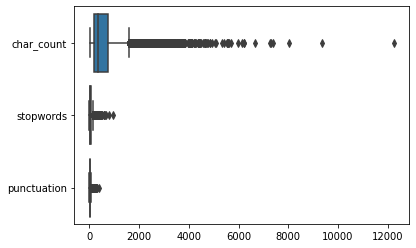

In [104]:
#compare the big 3
general = another[['char_count', 'stopwords', 'punctuation']]
ax = sns.boxplot(data=general, orient='h')

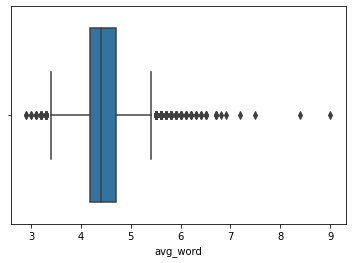

In [105]:
#average word distribution
ax = sns.boxplot(another['avg_word'], data=another)

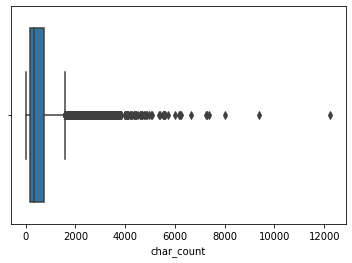

In [106]:
#char count distribution
ax = sns.boxplot(another['char_count'], data=another)

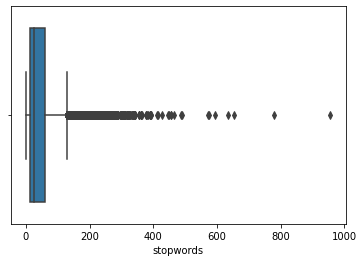

In [107]:
#stop words distribution
ax = sns.boxplot(another['stopwords'], data=another)

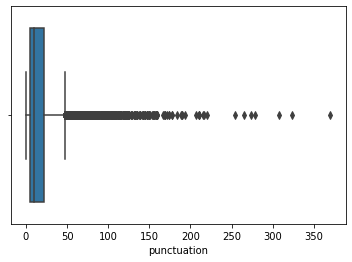

In [108]:
#punctuation distribution
ax = sns.boxplot(another['punctuation'], data=another)

Yep, indeed our data this time looks a lot of unwanted words or variables. Plus because this is NLP, so we can't do much other than "cleaning". Therefore in the next stage we will do additional "cleaning" at pre-processing

**Word Cloud**

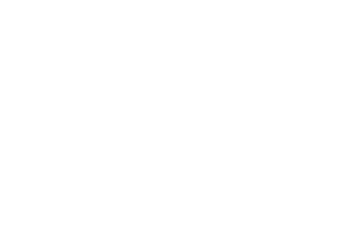

In [109]:
dam = another['reviewText'].iloc[:5]
#wordcloud = WordCloud().generate(dam)

#figure(figsize= (10,10), dpi= 120)
#plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Target Distribution**


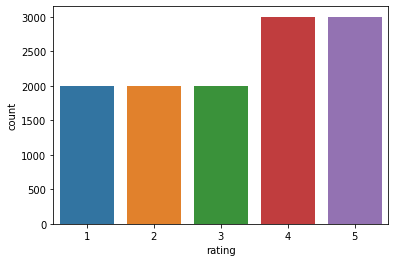

In [110]:
#visualize number counts of rating
sns.countplot('rating', data=another)

In [111]:
#exact counts from Rating Column
another.rating.value_counts()

5    3000
4    3000
3    2000
2    2000
1    2000
Name: rating, dtype: int64

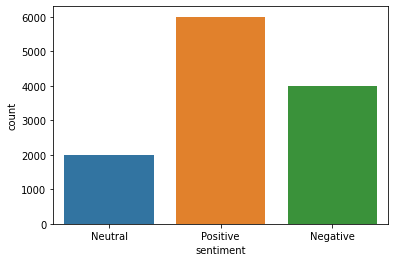

In [112]:
#target distribution based on sentiment
sns.countplot('sentiment', data=another)

In [113]:
#exact counts from Rating Column
another.rating.value_counts()

5    3000
4    3000
3    2000
2    2000
1    2000
Name: rating, dtype: int64

# 6. Data Preprocessing

### Pre-processing I (Case Folding)

In [114]:
#prepare the function
def remove_digits(string):
    return re.sub(r'\d+', '', string)

def remove_punctuation(text):
    return text.translate(str.maketrans("","", string.punctuation))

def remove_strip(text):
    return text.strip()

#define for stopwords
stop = stopwords.words('english')

In [115]:
another['reviewText'] = another['reviewText'].str.lower() #lowercase
another['reviewText'] = another['reviewText'].apply(remove_digits) #remove numbers
another['reviewText'] = another['reviewText'].apply(remove_punctuation) #remove punctuation
another['reviewText'] = another['reviewText'].apply(remove_strip) #remove whitespaces

another['reviewText'] = another['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [116]:
#clean part 2
def clean_text_round2(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [117]:
another['reviewText'] = another['reviewText'].apply(round2)

In [118]:
#clean part 3
def clean_text_round3(text):
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round3 = lambda x: clean_text_round3(x)

In [119]:
another['reviewText'] = another['reviewText'].apply(round3)

### Preprocessing II

In [120]:
#after
another = another[['reviewText', 'rating', 'sentiment']]
another.head()

,reviewText,rating,sentiment
0,jace rankin may short hes nothing mess man hau...,3,Neutral
1,great short read didnt want put read one sitti...,5,Positive
2,ill start saying first four books wasnt expect...,3,Neutral
3,aggie angela lansbury carries pocketbooks inst...,3,Neutral
4,expect type book library pleased find price right,4,Positive


In [121]:
X = another.reviewText
y = another.rating

#first split into X_train and X_remaining 80:20
X_train, X_rem, y_train, y_rem = train_test_split(X.to_numpy(), y, stratify = y, train_size=0.8)

#second split. from X_remain to X_val+X_test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

#numbers
print("Input Training:", X_train.shape), print("Output Training:", y_train.shape)
print("Input Val:", X_val.shape), print("Output Val:", y_val.shape)
print("Input Test:", X_test.shape), print("Output Test:", y_test.shape)

Input Training: (9600,)
Output Training: (9600,)
Input Val: (1200,)
Output Val: (1200,)
Input Test: (1200,)
Output Test: (1200,)


(None, None)

In [122]:
#encode target
def prepare_target(y_train, y_val, y_test):
  y_train_enc = to_categorical(y_train)
  y_val_enc = to_categorical(y_val)
  y_test_enc = to_categorical(y_test)
  return y_train_enc, y_val_enc, y_test_enc

y_train, y_val, y_test = prepare_target(y_train, y_val, y_test)

In [123]:
X_train[:6], y_train[:6]

(array(['perhaps book meant trite sarcastic waste time umm yeah goal guess need rethink rating umm actually book got two stars trite sarcastic writing style make laugh list traveling tips regarding traveling vampire many plain simple sorry first taste author glad freebie',
        'book laid little groundwork meacutenage story felt rushed plot fine bit mystery blended stretched credibility much taste things developed quickly',
        'read books cassandra carr enjoyed intrigued saw book contains novellas different authorsgoing remarkable pageturning read love hockey combination romance hockey winwin thoroughly enjoyed way authors intermingled stories yes read standalones miss anything great read one otheri usually pick novellas short concept definitely winner three short stories yet feel one story',
        'couldnt finish writing wasnt bad characters lexie wasnt bad wanted smack lucy upside head judgemental fundamentalist outlook life people appalling shes type christian gives christ

### Tokenization

In [124]:
#numbers for max_length
num_length = round(sum([len(i.split()) for i in X_train])/len(X_train))
num_length

54

In [125]:
# setup text vect
max_vocab_length = 10000
max_length = num_length

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length)

In [126]:
text_vectorization.adapt(X_train)

### Set Up Embedding Layer

In [127]:
output_dim = 64

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=output_dim,
                             embeddings_initializer="uniform",
                             input_length=max_length)

# 7. Model Definition

In [128]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Base Model

In [129]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
output = Dense(6, activation="softmax")(x)
base_model = keras.Model(inputs, output, name="base_model")

#compile
base_model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=["accuracy"])

In [130]:
#base model architecture
base_model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 54)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 54, 64)            640000    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 640,390
Trainable params: 640,390
Non-trai

### LSTM Model

In [131]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.LSTM(8)(x)
output = Dense(6, activation="softmax")(x)
lstm_model = keras.Model(inputs, output, name="lstm_model")

#compile
lstm_model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=["accuracy"])

In [132]:
#lstm model architecture
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 54)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 54, 64)            640000    
                                                                 
 lstm (LSTM)                 (None, 8)                 2336      
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
Total params: 642,390
Trainable params: 642,390
Non-trainable params: 0
__________________________________________________

### GRU Model

In [133]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
output = Dense(6, activation="softmax")(x)
gru_model = keras.Model(inputs, output, name="gru_model")

#compile
gru_model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=["accuracy"])

In [134]:
#GRU model architecture
gru_model.summary()

Model: "gru_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 54)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 54, 64)            640000    
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 665,350
Trainable params: 665,350
Non-trainable params: 0
___________________________________________________

# 8. Model Training

### Base Model

In [ ]:
#callback (optional)
callback1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
callback2 = tf.keras.callbacks.ModelCheckpoint(
    "base_model.h5",
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

base_history = base_model.fit(X_train, y_train, epochs=20, 
                              validation_data=(X_val, y_val),
                              callbacks=[callback1, callback2])

In [ ]:
base_model.evaluate(X_val, y_val)

38/38 [==============================] - 0s 2ms/step - loss: 1.3375 - accuracy: 0.4958


[1.3375155925750732, 0.4958333373069763]

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

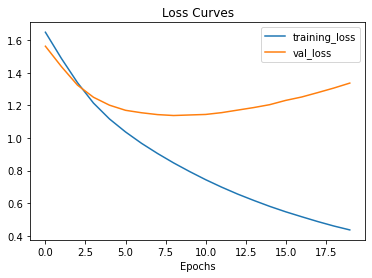

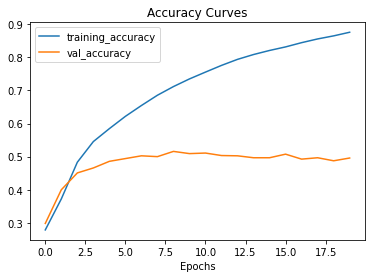

In [ ]:
plot_loss_curves(base_history)

In [ ]:
#classification report
from sklearn.metrics import classification_report

pred = base_model.predict(X_val)
pred = np.argmax(pred, axis=1)

y_pred = np.argmax(y_val, axis=1)

print(classification_report(y_pred, pred))

              precision    recall  f1-score   support

           1       0.51      0.62      0.56       195
           2       0.42      0.33      0.37       207
           3       0.42      0.35      0.38       202
           4       0.49      0.46      0.47       304
           5       0.56      0.67      0.61       292

    accuracy                           0.50      1200
   macro avg       0.48      0.49      0.48      1200
weighted avg       0.49      0.50      0.49      1200



### LSTM Model

In [ ]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, 
                              validation_data=(X_val, y_val))

Epoch 1/20
300/300 [==============================] - 15s 41ms/step - loss: 1.5336 - accuracy: 0.3727 - val_loss: 1.6290 - val_accuracy: 0.3208
Epoch 2/20
300/300 [==============================] - 10s 33ms/step - loss: 1.2285 - accuracy: 0.5043 - val_loss: 1.5099 - val_accuracy: 0.4233
Epoch 3/20
300/300 [==============================] - 10s 35ms/step - loss: 1.0097 - accuracy: 0.6230 - val_loss: 1.4619 - val_accuracy: 0.4258
Epoch 4/20
300/300 [==============================] - 10s 34ms/step - loss: 0.7648 - accuracy: 0.7437 - val_loss: 1.5045 - val_accuracy: 0.4408
Epoch 5/20
300/300 [==============================] - 11s 35ms/step - loss: 0.8861 - accuracy: 0.7018 - val_loss: 1.6947 - val_accuracy: 0.3983
Epoch 6/20
300/300 [==============================] - 10s 34ms/step - loss: 0.6582 - accuracy: 0.8107 - val_loss: 1.7404 - val_accuracy: 0.4283
Epoch 7/20
300/300 [==============================] - 10s 34ms/step - loss: 0.5417 - accuracy: 0.8558 - val_loss: 1.8691 - val_accuracy:

In [ ]:
lstm_model.evaluate(X_val, y_val)

38/38 [==============================] - 0s 7ms/step - loss: 2.4030 - accuracy: 0.4308


[2.402984380722046, 0.4308333396911621]

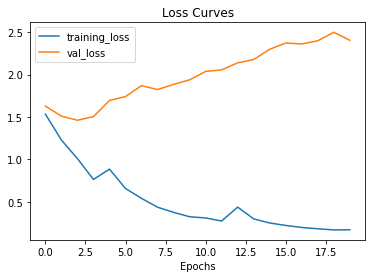

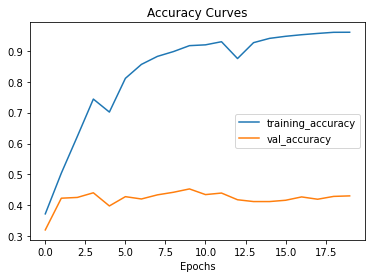

In [ ]:
plot_loss_curves(lstm_history)

In [ ]:
#classification report
from sklearn.metrics import classification_report

pred = lstm_model.predict(X_val)
pred = np.argmax(pred, axis=1)

y_pred = np.argmax(y_val, axis=1)

print(classification_report(y_pred, pred))

              precision    recall  f1-score   support

           1       0.45      0.52      0.49       195
           2       0.34      0.30      0.32       207
           3       0.33      0.28      0.30       202
           4       0.44      0.39      0.41       304
           5       0.51      0.61      0.55       292

    accuracy                           0.43      1200
   macro avg       0.41      0.42      0.42      1200
weighted avg       0.42      0.43      0.42      1200



### GRU Model

In [ ]:
gru_history = gru_model.fit(X_train, y_train, epochs=20, 
                              validation_data=(X_val, y_val))

Epoch 1/20
300/300 [==============================] - 17s 49ms/step - loss: 1.0559 - accuracy: 0.5493 - val_loss: 1.4305 - val_accuracy: 0.4658
Epoch 2/20
300/300 [==============================] - 14s 45ms/step - loss: 0.3002 - accuracy: 0.9002 - val_loss: 2.0067 - val_accuracy: 0.4350
Epoch 3/20
300/300 [==============================] - 14s 48ms/step - loss: 0.1952 - accuracy: 0.9402 - val_loss: 2.2761 - val_accuracy: 0.4167
Epoch 4/20
300/300 [==============================] - 13s 45ms/step - loss: 0.1494 - accuracy: 0.9554 - val_loss: 2.5440 - val_accuracy: 0.4158
Epoch 5/20
300/300 [==============================] - 13s 45ms/step - loss: 0.1182 - accuracy: 0.9655 - val_loss: 2.6214 - val_accuracy: 0.4183
Epoch 6/20
300/300 [==============================] - 13s 45ms/step - loss: 0.0967 - accuracy: 0.9728 - val_loss: 3.0040 - val_accuracy: 0.4133
Epoch 7/20
300/300 [==============================] - 14s 46ms/step - loss: 0.0825 - accuracy: 0.9759 - val_loss: 3.0702 - val_accuracy:

In [ ]:
gru_model.evaluate(X_val, y_val)

38/38 [==============================] - 0s 11ms/step - loss: 4.3405 - accuracy: 0.3908


[4.34048318862915, 0.3908333480358124]

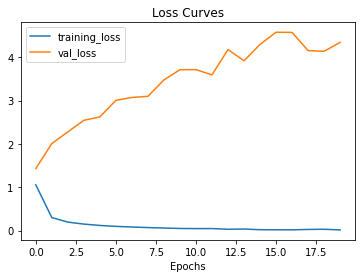

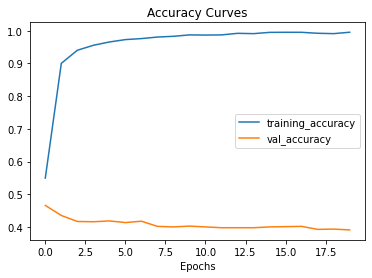

In [ ]:
plot_loss_curves(gru_history)

In [ ]:
#classification report
from sklearn.metrics import classification_report

pred = gru_model.predict(X_val)
pred = np.argmax(pred, axis=1)

y_pred = np.argmax(y_val, axis=1)

print(classification_report(y_pred, pred))

              precision    recall  f1-score   support

           1       0.46      0.46      0.46       195
           2       0.32      0.29      0.30       207
           3       0.29      0.34      0.31       202
           4       0.39      0.32      0.35       304
           5       0.47      0.52      0.50       292

    accuracy                           0.39      1200
   macro avg       0.38      0.39      0.38      1200
weighted avg       0.39      0.39      0.39      1200



# 9. Model Evaluation

Based on the three types of models that we have made above, the three of them can still be said to be less good models.

It can be seen that although the loss value and accuracy are good, when trained on validation data the results show that the three models tend to be overfitting.

However, overall what happens is that the base model is better at the beginning of the epoch. Therefore, I think it is necessary to do some improvement training by adding certain layers like Dropout. Later we will also try to use bidimensional layers.

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Model Improvement I (Vector+Embed+Bi+Bi+Dense)

In [ ]:
# setup text vect
max_vocab_length = 4000
max_length = num_length

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length)

text_vectorization.adapt(X_train)

In [ ]:
#embedding
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=64,
                             embeddings_initializer="uniform",
                             input_length=max_length)

In [ ]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
output = Dense(6, activation="softmax")(x)
imp_model = keras.Model(inputs, output, name="imp_model")

#compile
imp_model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=["accuracy"])

In [ ]:
#lstm model architecture
imp_model.summary()

Model: "imp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 54)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 54, 64)            256000    
                                                                 
 bidirectional (Bidirectiona  (None, 54, 128)          66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                         

In [76]:
imp_history = imp_model.fit(X_train, y_train, epochs=20, 
                                 validation_data=(X_val, y_val))

Epoch 1/20
300/300 [==============================] - 85s 284ms/step - loss: 0.5938 - accuracy: 0.7785 - val_loss: 1.6659 - val_accuracy: 0.4208
Epoch 2/20
300/300 [==============================] - 43s 144ms/step - loss: 0.5082 - accuracy: 0.8175 - val_loss: 1.8162 - val_accuracy: 0.4342
Epoch 3/20
300/300 [==============================] - 38s 128ms/step - loss: 0.4461 - accuracy: 0.8451 - val_loss: 1.9281 - val_accuracy: 0.4133
Epoch 4/20
300/300 [==============================] - 35s 117ms/step - loss: 0.3841 - accuracy: 0.8742 - val_loss: 2.0391 - val_accuracy: 0.4208
Epoch 5/20
300/300 [==============================] - 35s 118ms/step - loss: 0.3422 - accuracy: 0.8876 - val_loss: 2.2406 - val_accuracy: 0.4067
Epoch 6/20
300/300 [==============================] - 37s 125ms/step - loss: 0.3061 - accuracy: 0.9027 - val_loss: 2.3363 - val_accuracy: 0.4158
Epoch 7/20
300/300 [==============================] - 35s 117ms/step - loss: 0.2605 - accuracy: 0.9190 - val_loss: 2.4669 - val_ac

In [77]:
imp_model.evaluate(X_val, y_val)

38/38 [==============================] - 1s 29ms/step - loss: 3.8387 - accuracy: 0.3717


[3.838693857192993, 0.37166666984558105]

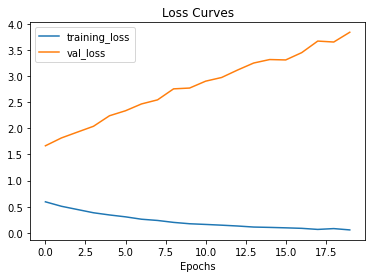

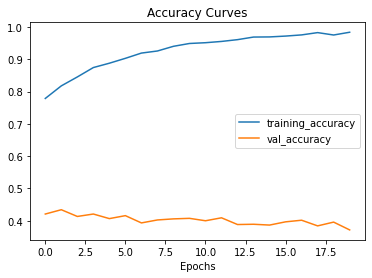

In [78]:
plot_loss_curves(imp_history)

In [79]:
#classification report
from sklearn.metrics import classification_report

pred = imp_model.predict(X_val)
pred = np.argmax(pred, axis=1)

y_pred = np.argmax(y_val, axis=1)
print(classification_report(y_pred, pred))

              precision    recall  f1-score   support

           1       0.38      0.43      0.40       195
           2       0.29      0.24      0.26       207
           3       0.29      0.33      0.31       202
           4       0.38      0.40      0.39       304
           5       0.48      0.43      0.45       292

    accuracy                           0.37      1200
   macro avg       0.36      0.36      0.36      1200
weighted avg       0.37      0.37      0.37      1200



### Model Improvement II (Vector+Embed+Global Average+Dropout+Batch Normalization+Dense)

In [139]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [140]:
# setup text vect
max_vocab_length = 10000
max_length = num_length

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length)

text_vectorization.adapt(X_train)

In [141]:
#embedding
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=64,
                             embeddings_initializer="uniform",
                             input_length=max_length)

In [142]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(rate=0.2)(x)
x = BatchNormalization()(x)
x = Dense(8)(x)
output = Dense(6, activation="softmax")(x)
sec_model = keras.Model(inputs, output, name="sec_model")

#compile
sec_model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=["accuracy"])

#second model architecture
sec_model.summary()

Model: "sec_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 54)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 54, 64)            640000    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               25

In [145]:
sec_history = sec_model.fit(X_train, y_train, epochs=20, 
                                 validation_data=(X_val, y_val))

Epoch 1/20
300/300 [==============================] - 6s 19ms/step - loss: 0.9801 - accuracy: 0.6115 - val_loss: 1.2352 - val_accuracy: 0.4717
Epoch 2/20
300/300 [==============================] - 5s 18ms/step - loss: 0.7438 - accuracy: 0.7189 - val_loss: 1.3739 - val_accuracy: 0.4650
Epoch 3/20
300/300 [==============================] - 6s 20ms/step - loss: 0.5724 - accuracy: 0.7849 - val_loss: 1.6068 - val_accuracy: 0.4500
Epoch 4/20
300/300 [==============================] - 3s 12ms/step - loss: 0.4620 - accuracy: 0.8304 - val_loss: 1.8434 - val_accuracy: 0.4292
Epoch 5/20
300/300 [==============================] - 6s 21ms/step - loss: 0.3844 - accuracy: 0.8547 - val_loss: 2.1069 - val_accuracy: 0.4317
Epoch 6/20
300/300 [==============================] - 6s 18ms/step - loss: 0.3215 - accuracy: 0.8806 - val_loss: 2.3841 - val_accuracy: 0.4225
Epoch 7/20
300/300 [==============================] - 4s 12ms/step - loss: 0.2895 - accuracy: 0.8953 - val_loss: 2.5929 - val_accuracy: 0.4375

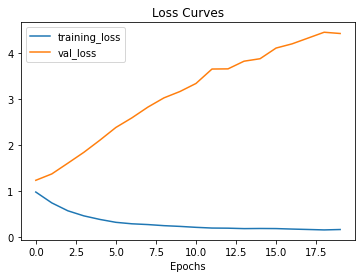

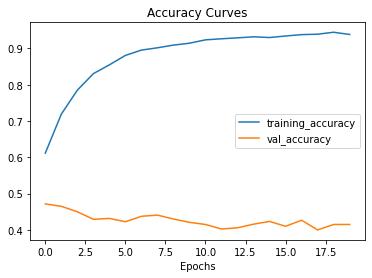

In [146]:
plot_loss_curves(sec_history)

In [147]:
#classification report
from sklearn.metrics import classification_report

pred = sec_model.predict(X_val)
pred = np.argmax(pred, axis=1)

y_pred = np.argmax(y_val, axis=1)
print(classification_report(y_pred, pred))

              precision    recall  f1-score   support

           1       0.46      0.39      0.42       200
           2       0.32      0.37      0.34       194
           3       0.30      0.27      0.29       202
           4       0.41      0.37      0.39       305
           5       0.52      0.61      0.56       299

    accuracy                           0.41      1200
   macro avg       0.40      0.40      0.40      1200
weighted avg       0.41      0.41      0.41      1200



### Model Improvement III

In [170]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [171]:
# setup text vect
max_vocab_length = 10000
max_length = num_length

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length)

text_vectorization.adapt(X_train)

In [172]:
#embedding
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=64,
                             embeddings_initializer="uniform",
                             input_length=max_length)

In [173]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x = Dense(8)(x)
output = Dense(6, activation="softmax")(x)
third_model = keras.Model(inputs, output, name="third_model")

#compile
third_model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=["accuracy"])

#second model architecture
third_model.summary()

Model: "third_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 54)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 54, 64)            640000    
                                                                 
 bidirectional (Bidirectiona  (None, 54, 128)          66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                       

In [174]:
third_history = third_model.fit(X_train, y_train, epochs=20, 
                                validation_data=(X_val, y_val))

Epoch 1/20
300/300 [==============================] - 60s 177ms/step - loss: 1.4555 - accuracy: 0.3168 - val_loss: 1.3048 - val_accuracy: 0.3892
Epoch 2/20
300/300 [==============================] - 54s 180ms/step - loss: 1.1282 - accuracy: 0.4785 - val_loss: 1.2586 - val_accuracy: 0.4408
Epoch 3/20
300/300 [==============================] - 57s 190ms/step - loss: 0.8915 - accuracy: 0.6030 - val_loss: 1.3465 - val_accuracy: 0.4408
Epoch 4/20
300/300 [==============================] - 44s 146ms/step - loss: 0.6932 - accuracy: 0.7214 - val_loss: 1.5139 - val_accuracy: 0.4367
Epoch 5/20
300/300 [==============================] - 38s 127ms/step - loss: 0.5311 - accuracy: 0.8026 - val_loss: 1.7237 - val_accuracy: 0.4333
Epoch 6/20
300/300 [==============================] - 52s 174ms/step - loss: 0.4094 - accuracy: 0.8583 - val_loss: 1.9303 - val_accuracy: 0.4167
Epoch 7/20
300/300 [==============================] - 50s 166ms/step - loss: 0.3244 - accuracy: 0.8909 - val_loss: 2.2231 - val_ac

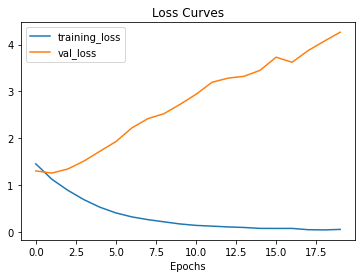

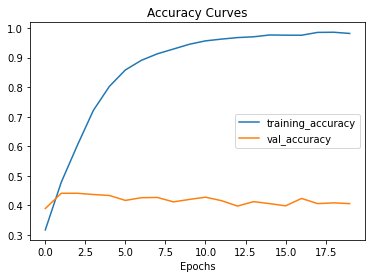

In [175]:
plot_loss_curves(third_history)

In [176]:
#classification report
from sklearn.metrics import classification_report

pred = third_model.predict(X_val)
pred = np.argmax(pred, axis=1)

y_pred = np.argmax(y_val, axis=1)
print(classification_report(y_pred, pred))

              precision    recall  f1-score   support

           1       0.47      0.36      0.41       200
           2       0.31      0.37      0.34       194
           3       0.30      0.26      0.28       202
           4       0.38      0.46      0.41       305
           5       0.56      0.50      0.53       299

    accuracy                           0.41      1200
   macro avg       0.40      0.39      0.39      1200
weighted avg       0.42      0.41      0.41      1200



# 10. Model Saving

In [181]:
import os

model_version = "0001"
model_name = "my_base_model"
model_path = os.path.join(model_name, model_version)
model_path

'my_base_model/0001'

In [182]:
tf.saved_model.save(base_model, model_path)

INFO:tensorflow:Assets written to: my_base_model/0001/assets


# 11. Model Inference

In [179]:
# predict on a sample text without padding.

sample_text = ('this book did not entertain me. terrible book. i would not recommend this book.')
sample_text2 = ('i always love how the author tell us his point of view.')

predictions1 = base_model.predict(np.array([sample_text]))
predictions2 = base_model.predict(np.array([sample_text2]))

print(predictions1.argmax(axis=1))
print(predictions2.argmax(axis=1))

[2]
[2]


# 12. Conclusion

1. In general this dataset can provide various Deep Learning models, including sentiment analysis on reviews given by users and prediction of star values from review sentences given by users. However, when compared to the selection of the Deep Learning model between sentiment analysis and prediction of the star value, I chose the prediction of the star value based on the consideration of the imbalance in the number of sentiments given by the user. So to minimize the results of wrong predictions, I chose to create a Deep Learning model to predict the star value only.

2. In terms of modeling, in general, this notebook has tried six Deep Learning models, namely the base model, LSTM model, GRU model, Bidirectional model, GlobalAverage with Dropout and Batch Normalization model, and the last one is the second Bidirectional model with a difference in the number of max vocabs and hidden layers. addition before the output layer. The results, based on the classification report, show that the first model, namely the base model, produces better prediction performance than the other five models. The details are as follows:

  1. Base Model
                        precision    recall  f1-score   support

                  1       0.51      0.62      0.56       195
                  2       0.42      0.33      0.37       207
                  3       0.42      0.35      0.38       202
                  4       0.49      0.46      0.47       304
                  5       0.56      0.67      0.61       292
          accuracy                            0.50      1200
          macro avg       0.48      0.49      0.48      1200
          weighted avg    0.49      0.50      0.49      1200
             
  2. LSTM Model
                        precision    recall  f1-score   support

                  1       0.45      0.52      0.49       195
                  2       0.34      0.30      0.32       207
                  3       0.33      0.28      0.30       202
                  4       0.44      0.39      0.41       304
                  5       0.51      0.61      0.55       292
          accuracy                            0.43      1200
          macro avg       0.41      0.42      0.42      1200
          weighted avg    0.42      0.43      0.42      1200
  3. GRU Model
                      precision    recall  f1-score   support

                  1       0.46      0.46      0.46       195
                  2       0.32      0.29      0.30       207
                  3       0.29      0.34      0.31       202
                  4       0.39      0.32      0.35       304
                  5       0.47      0.52      0.50       292
          accuracy                            0.39      1200
          macro avg       0.38      0.39      0.38      1200
          weighted avg    0.39      0.39      0.39      1200

  4. Bidirectional Model
                      precision    recall  f1-score   support

                  1       0.38      0.43      0.40       195
                  2       0.29      0.24      0.26       207
                  3       0.29      0.33      0.31       202
                  4       0.38      0.40      0.39       304
                  5       0.48      0.43      0.45       292
          accuracy                            0.37      1200
          macro avg       0.36      0.36      0.36      1200
          weighted avg    0.37      0.37      0.37      1200

  5. Global Avg+DropOut+Batch Norm Model
                      precision    recall  f1-score   support

                  1       0.46      0.39      0.42       200
                  2       0.32      0.37      0.34       194
                  3       0.30      0.27      0.29       202
                  4       0.41      0.37      0.39       305
                  5       0.52      0.61      0.56       299
          accuracy                            0.41      1200
          macro avg       0.40      0.40      0.40      1200
          weighted avg    0.41      0.41      0.41      1200

  6. Bidirectional with Extra Hidden Layer + Different Max Numbers of Vocab Model
                      precision    recall  f1-score   support

                  1       0.47      0.36      0.41       200
                  2       0.31      0.37      0.34       194
                  3       0.30      0.26      0.28       202
                  4       0.38      0.46      0.41       305
                  5       0.56      0.50      0.53       299
          accuracy                            0.41      1200
          macro avg       0.40      0.39      0.39      1200
          weighted avg    0.42      0.41      0.41      1200

3. From the modeling results above, it can be concluded that in the case of this dataset, a model that has a fairly good performance value is determined by a fairly large max vocab length value of 10,000. Meanwhile, other models with max vocab length values below 4000-5000-6000 tend to reduce the model's performance.

4. Then when comparing the 4th model and 6th model which both use a Bidirectional layer, the 6th model produces a better performance of 3-4% with the architecture added one additional hidden layer.

5. Again, in general the base model is the best model that we have built with the highest performance scores for predictions for all five classes.



---

FUTURE WORK
1. Try to use Tensorflow Hub
2. Mix another layer
3. Or try another Dataset